In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from pybedtools import BedTool
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy.spatial.distance import pdist, squareform
from plot_params import *
basedir= Path('/tscc/nfs/home/hsher/scratch/ABC_2rep/')
out_stem = 'K562_rep6'
#fl='/home/hsher/scratch/K562_rep4.count.csv'

In [2]:
megaoutputs_masked = pd.read_csv(basedir/'DMM_repeat'/'name'/f'{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)
megaoutputs_genome_masked = pd.read_csv(basedir/'DMM'/f'{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)


In [3]:
raw_counts = pd.read_csv(basedir/'counts'/'repeats'/'megatables'/'name'/f'{out_stem}.tsv.gz', sep = '\t', index_col = 0)
genome_counts = pd.read_csv(basedir/'counts'/'genome'/'megatables'/f'{out_stem}.tsv.gz', sep = '\t')

In [4]:
nreads = raw_counts.sum()+genome_counts.sum()
nreads.index = [i.split('.')[1] for i in nreads.index]

In [5]:
family_type = pd.read_csv(basedir/'DMM_repeat/name/K562_rep6.rbp_family_type.csv', index_col = 0)
family_type['n_reads'] = nreads

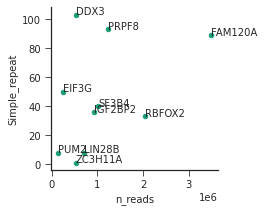

In [6]:
family_type.plot.scatter(x = 'n_reads', y = 'Simple_repeat', figsize = (3,3))
for index, row in family_type.iterrows():
    plt.text(row['n_reads'], row['Simple_repeat'], index)
sns.despine()

In [7]:
simplified = family_type.copy()
simplified.drop('n_reads', inplace = True, axis = 1)
rare = family_type.columns[family_type.le(5).all(axis = 0)]
simplified['other']=simplified[rare].sum(axis = 1)
simplified.drop(rare, axis = 1, inplace = True)

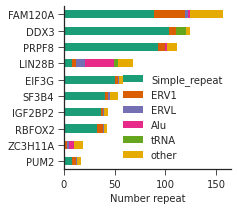

In [8]:
# show eCLIP
old_output_dir = Path('/tscc/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_re/')
def get_reproducible_re(rbp, pval_cutoff = 3, fc_cutoff = 3):
    
    
    reproducible = pd.read_csv(old_output_dir / f'{rbp}.reproducible_enriched_re.tsv.gz', sep = '\t',index_col = 0)
    return reproducible

In [9]:
old_output_dir2 = Path('/tscc/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_windows/')
def get_reproducible_peaks(rbp, pval_cutoff = 3, fc_cutoff = 3):
    
    
    reproducible = BedTool(old_output_dir2 / f'{rbp}_K562.reproducible_enriched_windows.tsv.gz')
    return reproducible

In [10]:
eclip_data = []
for rbp in [i.split('.')[1] for i in raw_counts.columns]:
    if rbp == 'DDX3':
        rbp = 'DDX3X'
    d = get_reproducible_re(f'{rbp}_K562')
    d['repFamily']=megaoutputs_masked['repFamily']
    eclip_cnt = d['repFamily'].value_counts()
    eclip_cnt.name = rbp
    eclip_data.append(eclip_cnt)
eclip_data = pd.concat(eclip_data, axis = 1).fillna(0)

In [11]:
other = eclip_data.loc[~eclip_data.index.isin(simplified.columns)].sum()
eclip_data.drop(eclip_data.index[~eclip_data.index.isin(simplified.columns)], inplace = True)
eclip_data.loc['other'] = other

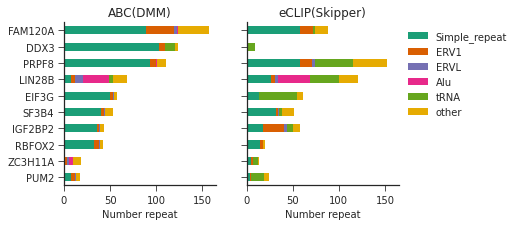

In [13]:
f, ax = plt.subplots(1,2, figsize = (6,3), sharex = True, sharey = True)
# plot DMM
simplified.loc[simplified.sum(axis = 1).sort_values().index].plot.barh(stacked = True,ax = ax[0], legend = False)

ax[0].set_xlabel('Number repeat')
ax[0].set_title('ABC(DMM)')
# plt.savefig(figdir / 'repeat_family.pdf')

eclip_data.rename({'DDX3X':'DDX3'}, axis = 1).T.loc[simplified.sum(axis = 1).sort_values().index, simplified.columns].plot.barh(
    stacked = True, ax = ax[1])
ax[1].set_xlabel('Number repeat')
ax[1].set_title('eCLIP(Skipper)')
sns.despine()
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('Number repeat')
plt.savefig(figdir / 'repeat_family.pdf')

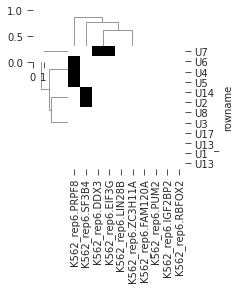

In [14]:
sns.clustermap(megaoutputs_masked.loc[(megaoutputs_masked['repFamily']=='snRNA'),
                      megaoutputs_masked.columns.str.startswith(out_stem)],
              figsize = (3,4), cmap = 'Greys', cbar = False)

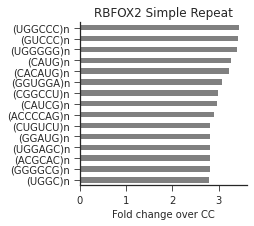

In [15]:
rbp = 'RBFOX2'
sub = megaoutputs_masked.loc[(megaoutputs_masked['repFamily']=='Simple_repeat')&
                                (megaoutputs_masked[f'{out_stem}.{rbp}']),
                                f'fc_raw:{out_stem}.{rbp}'].sort_values().iloc[:15]
sub.index = [i.replace('T', 'U') for i in sub.index]
sub.plot.barh(    color = 'grey', figsize = (3,3))
plt.xlabel('Fold change over CC')
plt.title(f'{rbp} Simple Repeat')
sns.despine()
plt.savefig(figdir / f'{rbp}_simple_repat.pdf')

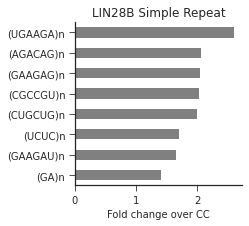

In [16]:
rbp = 'LIN28B'
sub = megaoutputs_masked.loc[(megaoutputs_masked['repFamily']=='Simple_repeat')&
                                (megaoutputs_masked[f'{out_stem}.{rbp}']),
                                f'fc_raw:{out_stem}.{rbp}'].sort_values().iloc[:15]
sub.index = [i.replace('T', 'U') for i in sub.index]
sub.plot.barh(    color = 'grey', figsize = (3,3))
plt.xlabel('Fold change over CC')
plt.title(f'{rbp} Simple Repeat')
sns.despine()
plt.savefig(figdir / f'{rbp}_simple_repat.pdf')

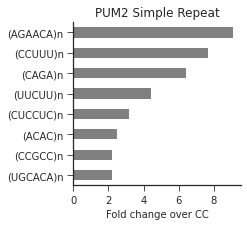

In [17]:
rbp = 'PUM2'
sub = megaoutputs_masked.loc[(megaoutputs_masked['repFamily']=='Simple_repeat')&
                                (megaoutputs_masked[f'{out_stem}.{rbp}']),
                                f'fc_raw:{out_stem}.{rbp}'].sort_values().iloc[:15]
sub.index = [i.replace('T', 'U') for i in sub.index]
sub.plot.barh(    color = 'grey', figsize = (3,3))
plt.xlabel('Fold change over CC')
plt.title(f'{rbp} Simple Repeat')
sns.despine()
plt.savefig(figdir / f'{rbp}_simple_repat.pdf')

In [18]:
def plot_mask(family, to_select = False, figsize = (3,3)):
    is_mask = megaoutputs_masked.loc[megaoutputs_masked['repFamily'].isin(family), megaoutputs_masked.columns.str.startswith(out_stem)]
    fc = megaoutputs_masked.loc[megaoutputs_masked['repFamily'].isin(family), megaoutputs_masked.columns.str.startswith('fc_raw:')]
    fc.columns = [i.split('.')[1] for i in fc.columns]
    is_mask.columns = [i.split('.')[1] for i in is_mask.columns]
    
    if to_select:
        to_plot = is_mask.index[is_mask.any(axis = 1)]
        sns.clustermap(fc.loc[to_plot],
                   figsize = figsize, cmap = 'Greys', yticklabels = 1,
                  mask = ~is_mask.loc[to_plot], cbar_kws = {'label':'FC raw'})
    else:
        sns.clustermap(fc,
                       figsize = figsize, cmap = 'Greys', yticklabels = 1,
                      mask = ~is_mask, cbar_kws = {'label':'FC raw'})

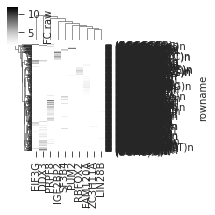

In [19]:
plot_mask(['Simple_repeat'], to_select = True, figsize = (3,3))
#plt.savefig(figdir / 'snRNA_family.pdf')

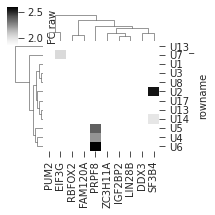

In [20]:
plot_mask(['snRNA'])
plt.savefig(figdir / 'snRNA_family.pdf')

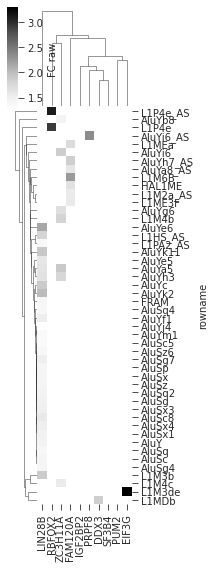

In [21]:
plot_mask(['L1', 'Alu'], to_select = True, figsize = (3,8))
plt.savefig(figdir / 'Alu_L1_family.pdf')

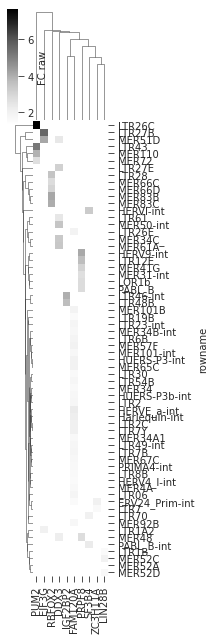

In [22]:
plot_mask(['ERV1', 'ERV1L'], to_select = True, figsize = (3,9))
plt.savefig(figdir / 'ERV_family.pdf')

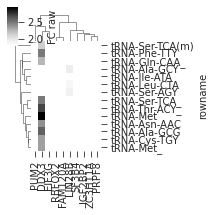

In [23]:
plot_mask(['tRNA'], to_select = True)
plt.savefig(figdir / 'tRNA_family.pdf')

In [24]:
small_rna_subset = megaoutputs_genome_masked.loc[megaoutputs_genome_masked['feature_type_top']=='EXON_SMALL']

In [25]:
enriched_type = []
for rbp in small_rna_subset.columns[small_rna_subset.columns.str.startswith(out_stem)]:
    cnt=small_rna_subset.loc[small_rna_subset[rbp], 'transcript_type_top'].value_counts()
    cnt.name = rbp
    enriched_type.append(cnt)
enriched_type = pd.concat(enriched_type, axis = 1).fillna(0).sort_index().T
enriched_type.index = [i.split('.')[1] for i in enriched_type.index]

In [26]:
ground_truth_skipper = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper.sum().sort_values()
skipper_genome = ground_truth_skipper.merge(megaoutputs_genome_masked[['feature_type_top', 'transcript_type_top']],
                          left_index = True, right_index = True)
small_rna_subset_eclip = skipper_genome.loc[skipper_genome['feature_type_top']=='EXON_SMALL']

enriched_type_eclip = []
for rbp in ground_truth_skipper.columns:
    cnt=small_rna_subset_eclip.loc[small_rna_subset_eclip[rbp], 'transcript_type_top'].value_counts()
    cnt.name = rbp
    enriched_type_eclip.append(cnt)
enriched_type_eclip = pd.concat(enriched_type_eclip, axis = 1).fillna(0).sort_index().T


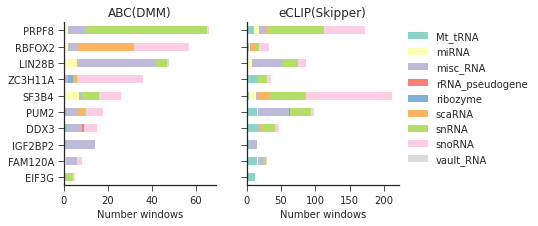

In [29]:
sns.set_palette('Set3')
f, ax = plt.subplots(1,2, figsize = (6,3), sharey = True)
enriched_type.loc[enriched_type.sum(axis = 1).sort_values().index].plot.barh(stacked = True, ax = ax[0], legend = False)

ax[0].set_xlabel('Number windows')
ax[0].set_title('ABC(DMM)')

enriched_type_eclip['ribozyme'] = 0
enriched_type_eclip.loc[enriched_type.sum(axis = 1).sort_values().index, enriched_type.columns].plot.barh(
    stacked = True, ax = ax[1])
ax[1].set_xlabel('Number windows')
ax[1].set_title('eCLIP(Skipper)')
plt.legend(bbox_to_anchor = (1,1))


sns.despine()
plt.savefig(figdir / 'smallRNA.pdf')

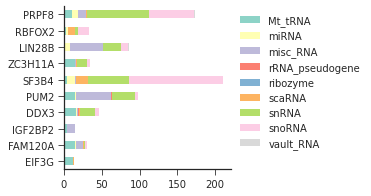

In [34]:
enriched_type.loc[enriched_type.sum(axis = 1).sort_values().index]

,Mt_tRNA,miRNA,misc_RNA,rRNA_pseudogene,ribozyme,scaRNA,snRNA,snoRNA,vault_RNA
EIF3G,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0
FAM120A,0.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0
IGF2BP2,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
DDX3,2.0,0.0,6.0,1.0,0.0,0.0,0.0,6.0,0.0
PUM2,0.0,0.0,6.0,0.0,0.0,3.0,1.0,8.0,0.0
SF3B4,0.0,7.0,1.0,0.0,0.0,0.0,8.0,10.0,0.0
ZC3H11A,0.0,0.0,2.0,0.0,2.0,2.0,0.0,30.0,0.0
LIN28B,0.0,6.0,36.0,0.0,0.0,0.0,5.0,0.0,1.0
RBFOX2,0.0,2.0,4.0,0.0,0.0,26.0,0.0,25.0,0.0
PRPF8,0.0,2.0,8.0,0.0,0.0,0.0,55.0,1.0,0.0


In [35]:
def plot_mask_genome(family, to_select = False, figsize = (3,3)):
    
    is_mask = megaoutputs_genome_masked.loc[megaoutputs_genome_masked['transcript_type_top'].isin(family), 
                                            megaoutputs_genome_masked.columns.str.startswith(out_stem)]
    fc = megaoutputs_genome_masked.loc[megaoutputs_genome_masked['transcript_type_top'].isin(family), 
                                       megaoutputs_genome_masked.columns.str.startswith('fc_raw:')]
    fc.columns = [i.split('.')[1] for i in fc.columns]
    is_mask.columns = [i.split('.')[1] for i in is_mask.columns]
    
    fc['name'] = [i.split(':')[-1] for i in megaoutputs_genome_masked.loc[fc.index, 'gene_name']]
    is_mask['name'] = [i.split(':')[-1] for i in megaoutputs_genome_masked.loc[fc.index, 'gene_name']]
    
    fc = fc.groupby(by = 'name').max()
    is_mask = is_mask.groupby(by = 'name').any()
    
    
    
    if to_select:
        to_plot = is_mask.index[is_mask.any(axis = 1)]
        sns.clustermap(fc.loc[to_plot],
                   figsize = figsize, cmap = 'Greys', yticklabels = 1,
                  mask = ~is_mask.loc[to_plot], cbar_kws = {'label':'FC raw'})
    else:
        sns.clustermap(fc,
                       figsize = figsize, cmap = 'Greys', yticklabels = 1,
                      mask = ~is_mask, cbar_kws = {'label':'FC raw'})

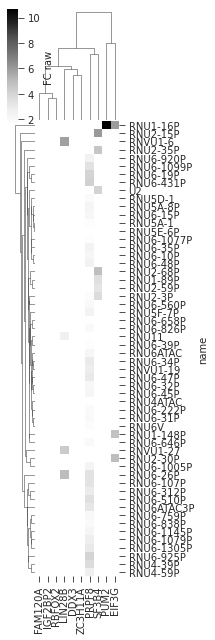

In [36]:
plot_mask_genome(['snRNA'], to_select = True, figsize = (3,9))
plt.savefig(figdir / 'RNU.pdf')

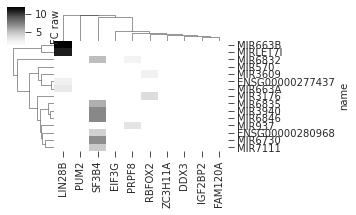

In [37]:
plot_mask_genome(['miRNA'], to_select = True, figsize = (5,3))
plt.savefig(figdir / 'miRNA.pdf')

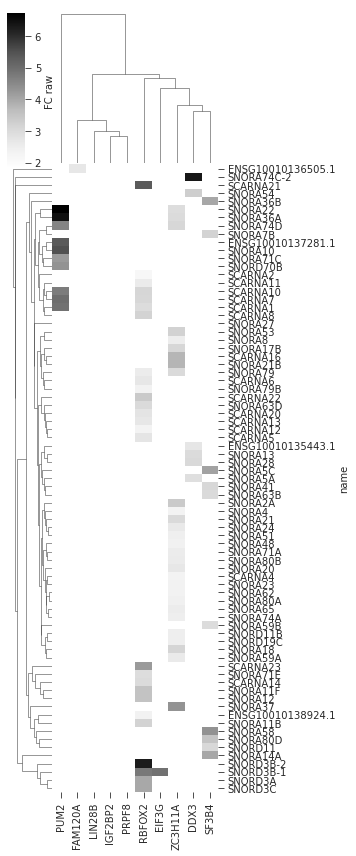

In [38]:
plot_mask_genome(['snoRNA', 'scaRNA'], to_select = True, figsize = (5,12))
plt.savefig(figdir / 'snoRNA.pdf')

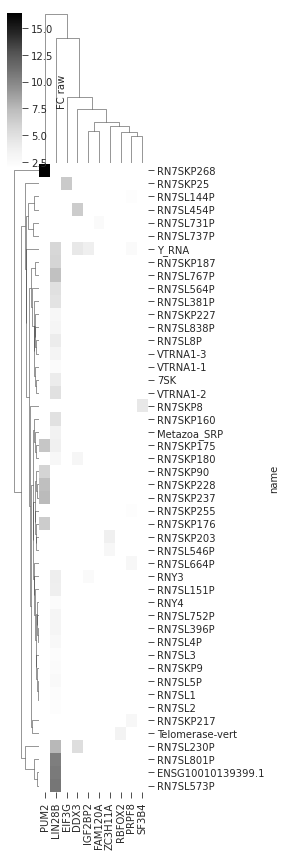

In [39]:
plot_mask_genome(['misc_RNA'], to_select = True, figsize = (4,12))
plt.savefig(figdir / 'miscRNA.pdf')

In [40]:
enriched_type_eclip

,Mt_rRNA,Mt_tRNA,miRNA,misc_RNA,rRNA,rRNA_pseudogene,scRNA,scaRNA,snRNA,snoRNA,vault_RNA,ribozyme
PRPF8,4.0,11.0,7.0,11.0,0.0,0.0,0.0,1.0,82.0,60.0,1.0,0
IGF2BP2,1.0,4.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
EIF3G,1.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
FAM120A,3.0,15.0,1.0,9.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0
SF3B4,5.0,4.0,10.0,2.0,1.0,0.0,0.0,16.0,54.0,125.0,0.0,0
RBFOX2,0.0,3.0,2.0,0.0,0.0,0.0,0.0,9.0,4.0,15.0,0.0,0
ZC3H11A,3.0,15.0,0.0,1.0,0.0,0.0,0.0,1.0,13.0,5.0,0.0,0
DDX3,3.0,16.0,1.0,2.0,0.0,1.0,0.0,1.0,20.0,6.0,0.0,0
PUM2,2.0,15.0,1.0,46.0,1.0,1.0,1.0,0.0,31.0,4.0,0.0,0
LIN28B,0.0,2.0,6.0,44.0,0.0,0.0,0.0,0.0,23.0,10.0,1.0,0
